In [1]:
# using Pkg
# Pkg.activate(dirname(pwd()))
using ComputationalHeatTransfer
using Plots
gr()  
using XLSX
using JLD2
using SparseArrays


┌ Info: Precompiling ComputationalHeatTransfer [5fc296c8-2eb5-40dc-a46d-98a68011a900]
└ @ Base loading.jl:1662


## Get fluid properties

In [2]:
fluid_type = "butane"
Tᵥ = 291.2

291.2

In [3]:
using UnPack

p_fluid = SaturationFluidProperty(fluid_type,Tᵥ)
@unpack Cpₗ,ρₗ,μₗ,hₗ,kₗ,Prₗ,Cpᵥ,ρᵥ,μᵥ,hᵥ,kᵥ,Prᵥ,σ,P,R,M,Rkg,αₗ,νₗ,νᵥ,hₗᵥ = p_fluid;

In [4]:
name_dict = [
    "ASETS-II OHP 1 SMALL HEATER_10W.jld2";
    "ASETS-II OHP 1 SMALL HEATER_20W.jld2";
    "ASETS-II OHP 1 SMALL HEATER_30W.jld2";
    "ASETS-II OHP 1 SMALL HEATER_40W.jld2";
    "ASETS-II OHP 1 LARGE HEATER_10W.jld2";
    "ASETS-II OHP 1 LARGE HEATER_20W.jld2";
    "ASETS-II OHP 1 LARGE HEATER_30W.jld2";
    "ASETS-II OHP 1 LARGE HEATER_40W.jld2";
    "ASETS-II OHP 2 SMALL HEATER_10W.jld2";
    "ASETS-II OHP 2 SMALL HEATER_20W.jld2";
    "ASETS-II OHP 2 SMALL HEATER_30W.jld2";
    "ASETS-II OHP 2 SMALL HEATER_40W.jld2";
    "ASETS-II OHP 2 LARGE HEATER_10W.jld2";
    "ASETS-II OHP 2 LARGE HEATER_20W.jld2";
    "ASETS-II OHP 2 LARGE HEATER_30W.jld2";
    "ASETS-II OHP 2 LARGE HEATER_40W.jld2";
];

name_exp_dict = [
    "20190607_F_PD_%23013_O001_H002_P010_expA.xlsx";
    "20190608_F_PD_%23014_O001_H002_P020_expA.xlsx";
    "20190614_F_PD_%23015_O001_H002_P030_expA.xlsx";
    "20190617_F_PD_%23016_O001_H002_P040_expA.xlsx";
    "20190604_F_PD_%23001_O001_H001_P010_expA.xlsx";
    "20190606_F_PD_%23002_O001_H001_P020_expA.xlsx";
    "20190612_F_PD_%23003_O001_H001_P030_expA.xlsx";
    "20190613_F_PD_%23004_O001_H001_P040_expA.xlsx";
    "20190607_F_PD_%23017_O002_H002_P010_expA.xlsx";
    "20190608_F_PD_%23018_O002_H002_P020_expA.xlsx";
    "20190614_F_PD_%23019_O002_H002_P030_expA.xlsx";
    "20190617_F_PD_%23020_O002_H002_P040_expA.xlsx";
    "20190604_F_PD_%23005_O002_H001_P010_expA.xlsx";
    "20190606_F_PD_%23006_O002_H001_P020_expA.xlsx";
    "20190612_F_PD_%23007_O002_H001_P030_expA.xlsx";
    "20190613_F_PD_%23008_O002_H001_P040_expA.xlsx";
];

In [13]:
OHPt_nume = Vector{Float64}[]
OHPg_nume = Vector{Vector{Float64}}[]
power_nume = Float64[]
for namei in name_dict
#     numerical
    power = parse(Int64,namei[findfirst("HEATER", namei)[end] .+ [2,3]])
#     OHPdata = load(dirname(dirname(dirname(pwd())))*"/OHPnume/Ca13E05_DT2/"*namei);
    OHPdata = load("/Users/yuxuanli/Documents/Hoffman/ohp38/OHPnume/"*namei);
    
    ohp = OHPdata["ohp"]
    boil_data = OHPdata["boil_data"]
    tube_hist_t = OHPdata["tube_hist_t"]
    tube_hist_θwall = OHPdata["tube_hist_θwall"]
    tube_hist_u = OHPdata["tube_hist_u"]
    integrator_tube = OHPdata["integrator_tube"]
    sysfinal = getsysfinal(tube_hist_u,tube_hist_θwall,integrator_tube);

    plate_T_hist = OHPdata["plate_T_hist"]

    integrator_plate = OHPdata["integrator_plate"]
    sys = integrator_plate.p
    
    
    x = [-2.75inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
    y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];
    X =  VectorData(x,y);
    H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
    g = ScalarData(X);
    ghist = getghist(g,H,plate_T_hist);
    thist = tube_hist_t;

    push!(OHPt_nume,thist)
    push!(OHPg_nume,ghist)
    push!(power_nume,power)
end

In [14]:
RTDt_hist = Vector{Float64}[]
RTD_hist = Matrix{Float64}[]
for namei in name_exp_dict
# experimental
    xf = XLSX.readxlsx(dirname(dirname(dirname(pwd())))*"/OHPexp/"*namei)

    Onum, Hnum, power_exp = getconfig(namei)
    RTD,RTDt = getRTD(xf,Onum);
    
    push!(RTDt_hist,RTDt)
    push!(RTD_hist,RTD)
end

## get temperature curve time series

In [15]:
# x_map = 0:1e-3:L
# Hwall = zeros(size(x_map)[1],length(sysfinal))
# for i in eachindex(sysfinal)
#     Hwall[:,i] = sysfinal[i].mapping.H_interp_liquidtowall[x_map]
# end

# function liquidorvapor(Hwall_one,liquidthres=1000,dryvaporthres=100)
#     indicator = (Hwall_one > dryvaporthres && Hwall_one < liquidthres) ? 0 : 1
# end

In [16]:
# indicator = liquidorvapor.(Hwall');

In [17]:
# ohpξ = 0:L/length(ohp.x):(L-L/length(ohp.x));
# x_thres = 2.5inch - 0.5inch*0.9;
# condenser_indicator = (ohp.x .> x_thres);
# condenser_indicator_matrix = hcat(condenser_indicator, condenser_indicator)';

In [18]:
# heatmap(x_map,thist,indicator,xlabel="ξ [m]", ylabel="t [s]",title="0->liquid, 1->vapor",ylim=(0,100))
# # heatmap!(ohpξ,[thist[1];thist[end]],condenser_indicator_matrix,color=palette([:white, :blue], 2),opacity=0.5,colorbar=true,colorbar_title="condenser")

In [19]:
using Statistics

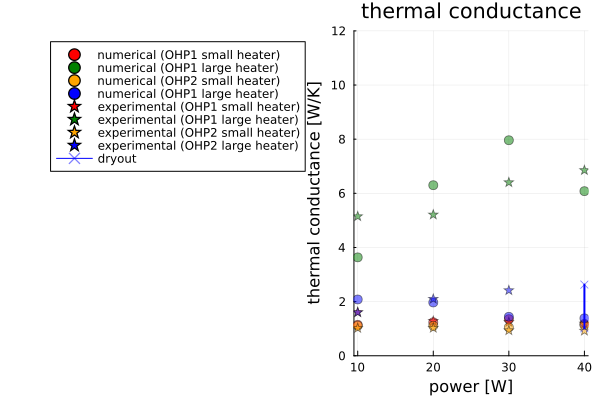

In [20]:
i1 = 8
i2 = 4
p1 = scatter(title = "thermal conductance",ylim=(0,12),xlim=(9.5,40.5),xlabel="power [W]", ylabel="thermal conductance [W/K]")
scatter!(p1, [0.0], [0.0], color=:red,label="numerical (OHP1 small heater)")
scatter!(p1, [0.0], [0.0], color=:green,label="numerical (OHP1 large heater)")
scatter!(p1, [0.0], [0.0], color=:orange,label="numerical (OHP2 small heater)")
scatter!(p1, [0.0], [0.0], color=:blue,label="numerical (OHP1 large heater)")
scatter!(p1, [0.0], [0.0], markershape=:star,color=:red,label="experimental (OHP1 small heater)")
scatter!(p1, [0.0], [0.0], markershape=:star,color=:green,label="experimental (OHP1 large heater)")
scatter!(p1, [0.0], [0.0], markershape=:star,color=:orange,label="experimental (OHP2 small heater)")
scatter!(p1, [0.0], [0.0], markershape=:star,color=:blue,label="experimental (OHP2 large heater)")
for j in 1:4
    scatter!(p1, markersize=5,markeralpha=0.5, legend=:outertopleft,[power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[50:100])],color=:red,label=false)
    scatter!(p1, markersize=5,markeralpha=0.5, [power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[50:100])],markershape=:star,color=:red,label=false)
end
for j in 5:8
    scatter!(p1, markersize=5,markeralpha=0.5,[power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[50:100])],color=:green,label=false)
    scatter!(p1, markersize=5,markeralpha=0.5,[power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[50:100])],markershape=:star,color=:green,label=false)
end
for j in 9:12
    scatter!(p1, markersize=5,markeralpha=0.5,[power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[50:100])],color=:orange,label=false)
    scatter!(p1, markersize=5,markeralpha=0.5,[power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[50:100])],markershape=:star,color=:orange,label=false)
end
for j in 13:15
    scatter!(p1, markersize=5,markeralpha=0.5,[power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[50:100])],color=:blue,label=false)
    scatter!(p1, markersize=5,markeralpha=0.5,[power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[50:100])],markershape=:star,color=:blue,label=false)
end
j = 16
 scatter!(p1, markersize=5,markeralpha=0.5,[power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[50:100])],color=:blue,label=false)
plot!(p1, [power_nume[j],power_nume[j]],linewidth=2,markeralpha=0.5,[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[50:70]),mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[170:200])],color=:blue,label="dryout",markershape=:x)
savefig(p1,"conductance.pdf")
p1

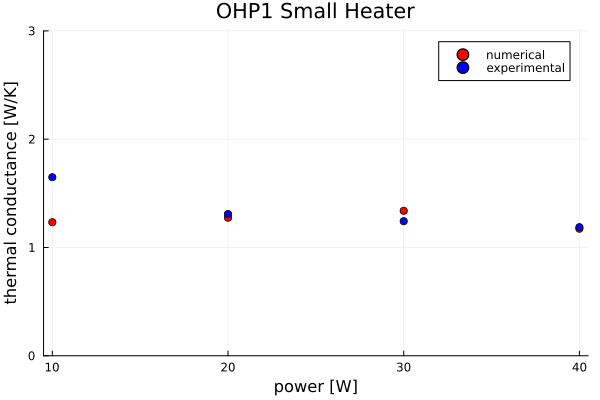

In [21]:
i1 = 8
i2 = 4
p1 = scatter(title = "OHP1 Small Heater",ylim=(0,3),xlim=(9.5,40.5),xlabel="power [W]", ylabel="thermal conductance [W/K]")
scatter!(p1, [0.0], [0.0], color=:red,label="numerical")
scatter!(p1, [0.0], [0.0], color=:blue,label="experimental")
for j in 1:4
    scatter!(p1, [power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[70:100])],color=:red,label=false)
    scatter!(p1, [power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[70:100])],color=:blue,label=false)
end
savefig(p1,"OHP1 Small Heater.pdf")
p1

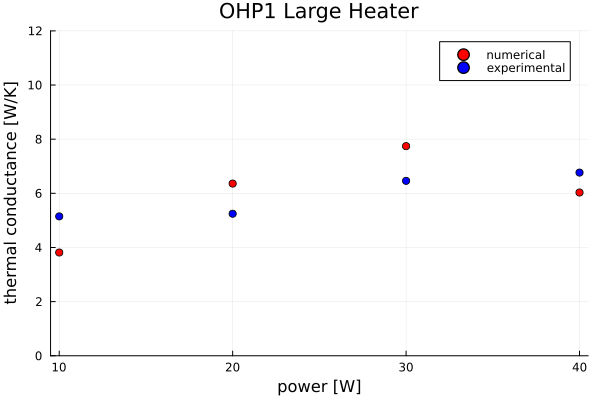

In [22]:
i1 = 8
i2 = 4
p1 = scatter(title = "OHP1 Large Heater",ylim=(0,12),xlim=(9.5,40.5),xlabel="power [W]", ylabel="thermal conductance [W/K]")
scatter!(p1, [0.0], [0.0], color=:red,label="numerical")
scatter!(p1, [0.0], [0.0], color=:blue,label="experimental")
for j in 5:8
    scatter!(p1, [power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[70:100])],color=:red,label=false)
    scatter!(p1, [power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[70:100])],color=:blue,label=false)
end
# j=8
#  scatter!(p1, [power_nume[j]],[5.91],color=:red,label=false)
# scatter!(p1, [power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[90:100])],color=:blue,label=false)


savefig(p1,"OHP1 Large Heater.pdf")
p1

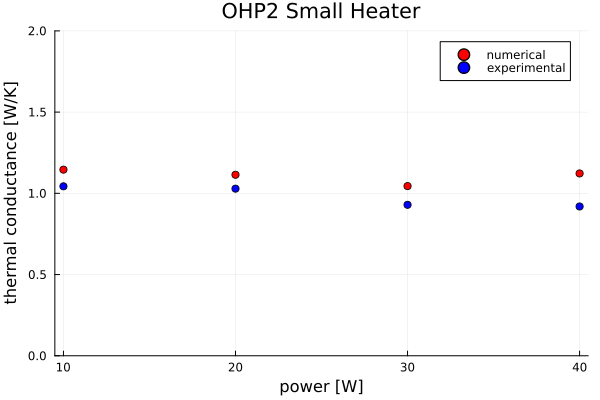

In [23]:
i1 = 8
i2 = 4
p1 = scatter(title = "OHP2 Small Heater",ylim=(0,2),xlim=(9.5,40.5),xlabel="power [W]", ylabel="thermal conductance [W/K]")
scatter!(p1, [0.0], [0.0], color=:red,label="numerical")
scatter!(p1, [0.0], [0.0], color=:blue,label="experimental")
for j in 9:12
    scatter!(p1, [power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[70:100])],color=:red,label=false)
    scatter!(p1, [power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[70:100])],color=:blue,label=false)
end
savefig(p1,"OHP2 Small Heater.pdf")
p1

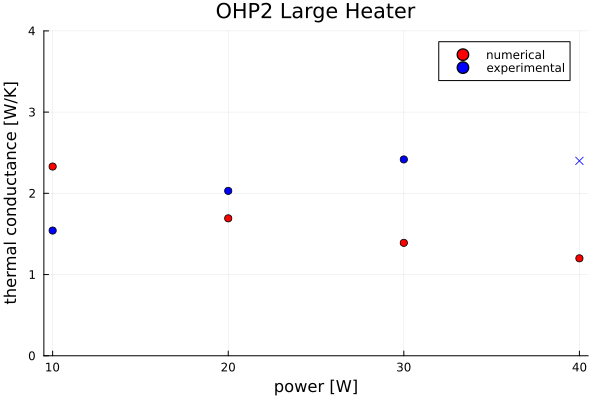

In [24]:
i1 = 8
i2 = 4
p1 = scatter(title = "OHP2 Large Heater",ylim=(0,4),xlim=(9.5,40.5),xlabel="power [W]", ylabel="thermal conductance [W/K]")
scatter!(p1, [0.0], [0.0], color=:red,label="numerical")
scatter!(p1, [0.0], [0.0], color=:blue,label="experimental")
for j in 13:15
    scatter!(p1, [power_nume[j]],[mean(power_nume[j] ./ (OHPg_nume[j][i2]-OHPg_nume[j][i1])[70:100])],color=:red,label=false)
    scatter!(p1, [power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[70:100])],color=:blue,label=false)
end
j = 16
 scatter!(p1, [power_nume[j]],[1.2],color=:red,label=false)
 
scatter!(p1, [power_nume[j]],[mean(power_nume[j] ./ (RTD_hist[j][:,i2]-RTD_hist[j][:,i1])[70:100])],color=:blue,label=false,markershape=:x)

savefig(p1,"OHP2 Large Heater.pdf")
p1

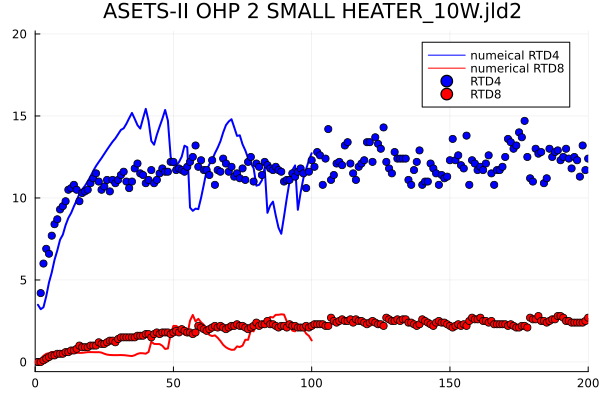

In [38]:
i = 9
plot(OHPt_nume[i],OHPg_nume[i][i2] .- OHPg_nume[i][i1][1],xlim=(0,200),title=name_dict[i],label="numeical RTD"*string(i2),linewidth=2,color=:blue)
plot!(OHPt_nume[i],OHPg_nume[i][i1].- OHPg_nume[i][i1][1],label="numerical RTD"*string(i1),linewidth=2,color=:red)
scatter!(RTDt_hist[i],RTD_hist[i][:,i2] .- RTD_hist[i][:,i2][1],label="RTD"*string(i2),color=:blue)
scatter!(RTDt_hist[i],RTD_hist[i][:,i1] .- RTD_hist[i][:,i1][1],label="RTD"*string(i1),color=:red)

# savefig("temperature curve.pdf")

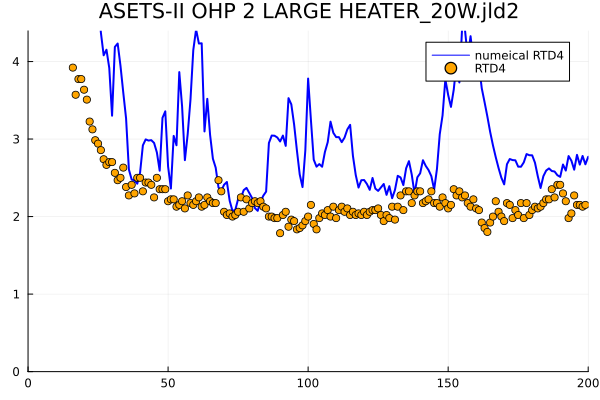

In [45]:
i =14
plot(OHPt_nume[i],power_nume[i] ./ (OHPg_nume[i][i2] .- OHPg_nume[i][i1]),xlim=(0,200),ylim=(0,5),title=name_dict[i],label="numeical RTD"*string(i2),linewidth=2,color=:blue)
scatter!(RTDt_hist[i],power_nume[i] ./ (RTD_hist[i][:,i2] .- RTD_hist[i][:,i1]),label="RTD"*string(i2),color=:orange,ylim=(0,2*power_nume[i] ./(RTD_hist[i][50,i2] .- RTD_hist[i][50,i1])))
# savefig("conductance curve.pdf")

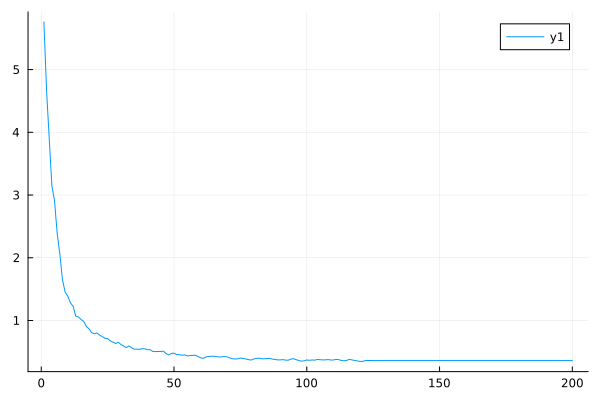

In [19]:
plot(10 ./ (OHPg_nume[i][i2] .- OHPg_nume[i][i1]))

In [20]:
Hₗ = 462
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
    plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :green]),line_z=Htmp_marker,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist_t[i], digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

LoadError: UndefVarError: sysfinal not defined

In [22]:
length(sysfinal[1].liquid.Xarrays)

30

In [23]:
for i = 1 : length(sysfinal[3].liquid.Xarrays)
    println(sysfinal[end].liquid.Xarrays[i][2]- sysfinal[end].liquid.Xarrays[i][1])
end

0.0013831343476327085
0.001355283443403632
0.0008570607853353174
0.001143474535411304
0.0008117933096425389
0.0012091361464521277
0.000981153410287483
0.0010895588932688938
0.0008390429196123428
0.001152702245172943
0.0009776776937364673
0.0009668442263768284
0.0009083812319117257
0.0006384818736133724
0.0011695285289694546
0.001062844979824007
0.0008811142921034687
0.001028331618692313
0.0008822740931329065


In [24]:
minimum(sysfinal[end-100].vapor.δstart)

1.3233285949135222e-5